# 1.6 Error estimation & adaptive refinement


In this tutorial, we apply a Zienkiewicz-Zhu type error estimator and run an adaptive loop with these steps:
$$
\text{SOLVE}\rightarrow
\text{ESIMATE}\rightarrow
\text{MARK}\rightarrow
\text{REFINE}\rightarrow
\text{SOLVE} \rightarrow \ldots
$$

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
import matplotlib.pyplot as plt

### Geometry

The following geometry represents a heated chip embedded in another material that conducts away the heat.

In [2]:
def MakeGeometryOCC():
    base = Rectangle(1, 0.6).Face()
    chip = MoveTo(0.5,0.15).Line(0.15,0.15).Line(-0.15,0.15).Line(-0.15,-0.15).Close().Face()
    top = MoveTo(0.2,0.6).Rectangle(0.6,0.2).Face()
    base -= chip

    base.faces.name="base"
    chip.faces.name="chip"
    chip.faces.col=(1,0,0)
    top.faces.name="top"
    geo = Glue([base,chip,top])
    geo.edges.name="default"
    geo.edges.Min(Y).name="bot"
    return OCCGeometry(geo, dim=2)

mesh = Mesh(MakeGeometryOCC().GenerateMesh(maxh=0.2))
Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

### Spaces & forms

The problem is to find $u$ in $H_{0,D}^1$ satisfying 

$$
\int_\Omega \lambda \nabla u \cdot \nabla v = \int_\Omega f v 
$$

for all $v$ in $H_{0,D}^1$. We expect the solution to have singularities due to the nonconvex re-enrant angles and discontinuities in $\lambda$.

In [3]:
fes = H1(mesh, order=2, dirichlet=[1])
u, v = fes.TnT()

# one heat conductivity coefficient per sub-domain
lam = CoefficientFunction([1, 1000, 10])
a = BilinearForm(lam*grad(u)*grad(v)*dx)

# heat-source in inner subdomain
f = LinearForm(fes)
f = LinearForm(1*v*dx(definedon="chip"))

c = Preconditioner(a, type="multigrid", inverse="sparsecholesky")

gfu = GridFunction(fes)

In [4]:
Draw(lam, mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

Note that the linear system is not yet assembled above.

### Solve 

Since we must solve multiple times, we define a function to solve the boundary value problem, where assembly, update, and solve occurs.

In [4]:
def SolveBVP():
    fes.Update()
    gfu.Update()
    a.Assemble()
    f.Assemble()
    inv = CGSolver(a.mat, c.mat)
    gfu.vec.data = inv * f.vec

In [5]:
SolveBVP()
Draw(gfu);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

### Estimate

We implement a gradient-recovery-type error estimator. For this, we need an H(div) space for flux recovery. We must compute the flux  of the computed solution and interpolate it into this H(div) space.

In [11]:
space_flux = HDiv(mesh, order=1)
gf_flux = GridFunction(space_flux, "flux")

flux = lam * grad(gfu)
gf_flux.Set(flux)

In [7]:
Draw(flux, mesh)
Draw(gf_flux, mesh)
Draw(flux-gf_flux, mesh)


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

**Element-wise error estimator:** On each element $T$, set 

$$
\eta_T^2 = \int_T \frac{1}{\lambda} 
|\lambda \nabla u_h - I_h(\lambda \nabla u_h) |^2
$$

where $u_h$ is the computed solution `gfu` and $I_h$ is the interpolation performed by `Set` in NGSolve.


In [9]:
err = 1/lam*(flux-gf_flux)*(flux-gf_flux)
Draw(err, mesh, 'error_representation')

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [10]:
eta2 = Integrate(err, mesh, VOL, element_wise=True)
print(eta2)
eta3 = Integrate(err, mesh, VOL)
print(eta3)

 6.67168e-08
 8.95385e-08
 8.76338e-06
 5.39369e-08
 5.38392e-08
 2.67624e-08
 3.54673e-07
 8.18615e-09
 2.94456e-08
 5.49887e-08
 8.50852e-08
 2.15923e-07
 1.08956e-07
 2.15925e-06
 7.19512e-06
 2.5243e-06
 8.35823e-08
 7.06374e-06
 3.40678e-06
 5.33454e-08
 1.84146e-07
 7.03089e-08
 1.28173e-06
 1.8683e-06
 2.66358e-07
 2.57079e-06
 3.80712e-08
 1.63147e-06
 8.95445e-07
 1.13184e-07
 1.00652e-07
 4.18728e-08
 2.43385e-08
 2.38783e-08
 9.95228e-09
 1.41123e-09
 4.48098e-09
 4.49434e-09
 1.44414e-09
 4.57478e-09

4.1534449127699115e-05


The above values, one per element, lead us to identify elements which might have large error.


### Mark 

We mark elements with large error estimator for refinement.

In [11]:
maxerr = max(eta2)
print ("maxerr = ", maxerr)

for el in mesh.Elements():
    mesh.SetRefinementFlag(el, eta2[el.nr] > 0.25*maxerr)
    # see below for vectorized alternative

maxerr =  8.763384084571335e-06


### Refine & solve again 

Refine marked elements:

In [12]:
mesh.Refine()
SolveBVP()
Draw(gfu)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

### Automate the above steps

In [13]:
l = []    # l = list of estimated total error

def CalcError():

    # compute the flux:
    space_flux.Update()      
    gf_flux.Update()
    flux = lam * grad(gfu)        
    gf_flux.Set(flux) 
    
    # compute estimator:
    err = 1/lam*(flux-gf_flux)*(flux-gf_flux)
    eta2 = Integrate(err, mesh, VOL, element_wise=True)
    maxerr = max(eta2)
    l.append ((fes.ndof, sqrt(sum(eta2))))
    print("ndof =", fes.ndof, " maxerr =", maxerr)
    
    # mark for refinement (vectorized alternative)
    mesh.ngmesh.Elements2D().NumPy()["refine"] = eta2.NumPy() > 0.25*maxerr

In [14]:
CalcError()
mesh.Refine()

ndof = 181  maxerr = 5.817959275434286e-06


### Run the adaptive loop

In [15]:
level = 0 
while fes.ndof < 1000:  
    SolveBVP()
    level = level + 1
    if level%5 == 0:
        print('adaptive step #', level)
        Draw(gfu)
    CalcError()
    mesh.Refine()

ndof = 255  maxerr = 2.170493419886722e-06
ndof = 426  maxerr = 8.625252217350138e-07
ndof = 638  maxerr = 3.426639969974725e-07
ndof = 881  maxerr = 1.359698758087195e-07
adaptive step # 5


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

ndof = 1205  maxerr = 5.39156654422276e-08


### Plot history of adaptive convergence

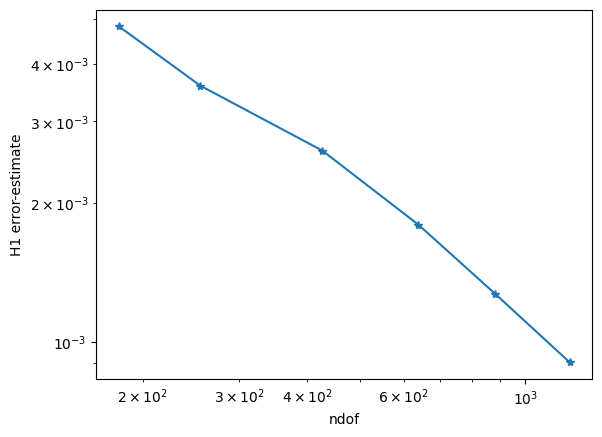

In [16]:
plt.yscale('log')
plt.xscale('log')
plt.xlabel("ndof")
plt.ylabel("H1 error-estimate")
ndof,err = zip(*l)
plt.plot(ndof,err, "-*")

plt.ion()
plt.show()

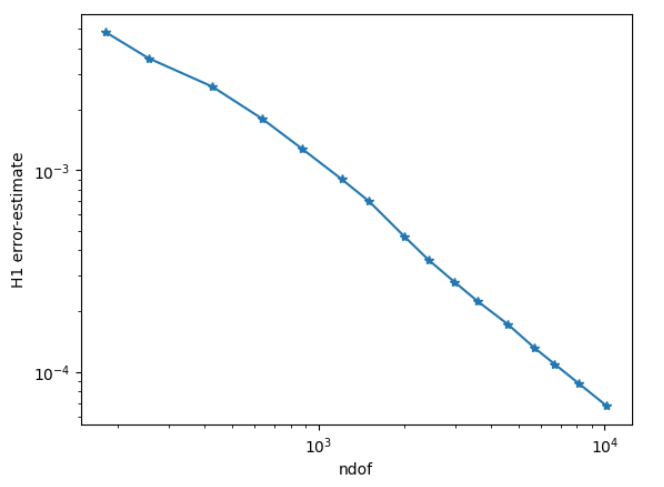